# Analyze the results from calculating background numbers for all configs

## July 20th

I performed a scan (~1000 times) scrambling the position of the source for a fixed SNR cut (starting with diffuse cut), and calculated the number of events that passed all cuts, then this result was averaged by the number of times the scrambling was done. We'd like to lower the SNR cut until we get a number of backgrounds similar to that obtained in the diffuse analysis.

I had to re-run imposing a new cut, since the files that Brian gave me have an outdated version of the cut

In [ ]:
import sys
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd


In [7]:
f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/bkg_random_SNR_scan_config1.root")
f.ls()
tree = f.Get("SNR_scan_c1")
tree.Print()


TFile**		/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/bkg_random_SNR_scan_config1.root	
 TFile*		/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/bkg_random_SNR_scan_config1.root	
  KEY: TTree	SNR_scan_c1;1	SNR_scan_c1
  KEY: TH2D	;1	H Data
******************************************************************************
*Tree    :SNR_scan_c1: SNR_scan_c1                                            *
*Entries :     1005 : Total =          147813 bytes  File  Size =     102389 *
*        :          : Tree compression factor =   1.33                       *
******************************************************************************
*Br    0 :phi       : phi/D                                                  *
*Entries :     1005 : Total  Size=      27842 bytes  File Size  =      23517 *
*Baskets :      201 : Basket Size=      32000 bytes  Compression=   1.00     *
*.....................................................

In [86]:
phi = tree.AsMatrix(["theta"]).ravel()
theta = tree.AsMatrix(["phi"]).ravel()
numPassAll = []
SNR_intercept = []
tree.GetEvent(0)
SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
for i in range(0, tree.GetEntries()):
    tree.GetEvent(i)
    numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
    #for arrays

In [41]:
# colNames = ["phi", 'theta'] + ["%.1f" % x for x in SNR_intercept]
colNames = ["%.1f" % x for x in SNR_intercept]
colNames

['20.0', '19.5', '19.0', '18.5', '18.0', '17.5']

In [82]:
# phi = np.array(phi).ravel()
d1 = pd.DataFrame(data=numPassAll, columns=colNames)
means = pd.DataFrame(data=d1.mean(), columns=["bkg"]).reset_index()
means = means.sort_values(by="index")

In [47]:
d2 = {'phi': phi, 'theta': theta}
d2 = pd.DataFrame(d2)
d2.tail()

,phi,theta
1000,-45.450652,-27.073227
1001,56.401853,0.169075
1002,-44.069650,83.434568
1003,78.023684,38.852614
1004,79.647443,43.643556


In [50]:
df = pd.concat([d2, d1], axis=1, sort=False)
df = df.loc[df.theta<17]

Text(0,0.5,'$\\theta$')

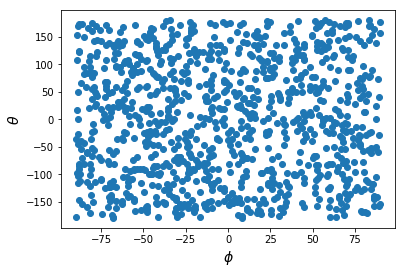

In [53]:
plt.scatter(df.phi,df.theta)
plt.xlabel("$\phi$", fontsize=14)
# plt.ylabel("$\cos(\\theta$)", fontsize=14)
plt.ylabel("$\\theta$", fontsize=14)

In [128]:
means["index"][:-2]

7    17.5
6    18.0
5    18.5
4    19.0
3    19.5
2    20.0
Name: index, dtype: object

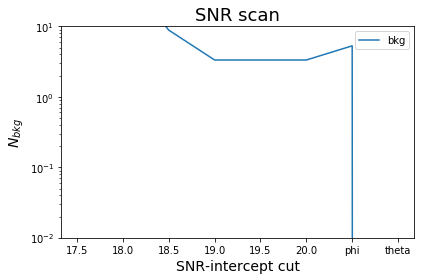

In [129]:
# plt.axhline(5E-2, ls="--", c="C1", label="Diffuse $N_{bkg}$ SNR cut = 20.6")
# plt.axvline(20.6, ls="--", c="C2", label="Diffuse SNR cut")


plt.plot(means["index"], means.bkg)
plt.yscale('log')
plt.ylim(0.01,10)
plt.xlabel("SNR-intercept cut", fontsize=14)
plt.ylabel("$N_{bkg}$", fontsize=14)
plt.title("SNR scan",fontsize=18)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/scan_yinterc_scrambled_source.png", dpi=150)

### Loop over configs

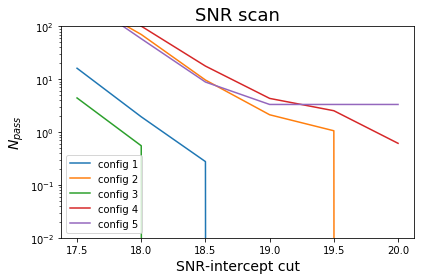

In [135]:
for j in range(1,6):
    f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/bkg_random_SNR_scan_config%i.root"%j)
    tree = f.Get("SNR_scan_c%i"%j)
    theta = tree.AsMatrix(["theta"]).ravel()
    phi = tree.AsMatrix(["phi"]).ravel()
    numPassAll = []
    SNR_intercept = []
    tree.GetEvent(0)
    SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
    for i in range(0, tree.GetEntries()):
        tree.GetEvent(i)
        numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
        #for arrays
    d1 = pd.DataFrame(data=numPassAll, columns=colNames)
    d2 = {'phi': phi, 'theta': theta}
    d2 = pd.DataFrame(d2)
    df = pd.concat([d2, d1], axis=1, sort=False)
    df = df.loc[df.theta<17]    
    means = pd.DataFrame(data=df.mean(), columns=["bkg"]).reset_index()
    means = means.sort_values(by="index")
    plt.plot(means["index"][:-2], means.bkg[:-2], label = "config %i"%j)
plt.yscale('log')
plt.ylim(0.01,100)
plt.xlabel("SNR-intercept cut", fontsize=14)
plt.ylabel("$N_{pass}$", fontsize=14)
plt.title("SNR scan",fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig("./plots/scan_yinterc_scrambled_source_allConfigs.png", dpi=150)


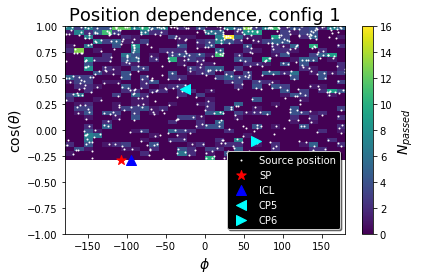

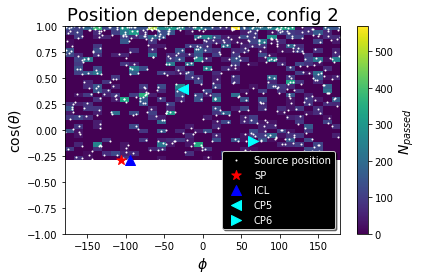

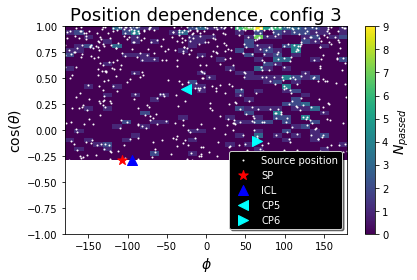

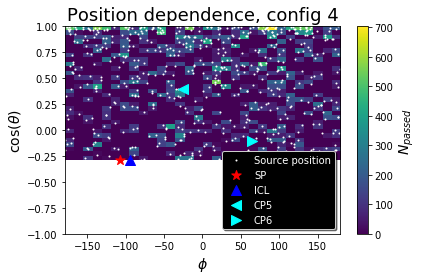

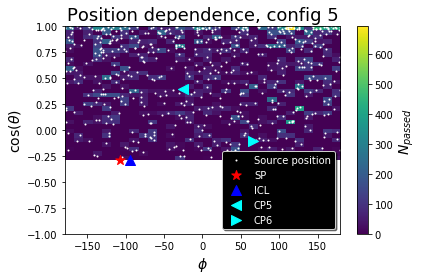

In [144]:
for j in range(1,6):
    f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/bkg_random_SNR_scan_config%i.root"%j)
    tree = f.Get("SNR_scan_c%i"%j)
    phi = tree.AsMatrix(["phi"]).ravel()
    theta = tree.AsMatrix(["theta"]).ravel()
    numPassAll = []
    SNR_intercept = []
    tree.GetEvent(0)
    SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
    for i in range(0, tree.GetEntries()):
        tree.GetEvent(i)
        numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
        #for arrays
   
    d1 = pd.DataFrame(data=numPassAll, columns=colNames)
    d2 = {'phi': phi, 'theta': theta}
    d2 = pd.DataFrame(d2)
    df = pd.concat([d2, d1], axis=1, sort=False)
    df = df.loc[df.theta<17]
    plt.figure()
    plt.hist2d(df.phi,np.cos(np.deg2rad(df.theta+90)), weights=df["18.0"], bins=30)
#     plt.hist2d(df.phi,df.theta, weights=df["18.0"], bins=30)
    cbar = plt.colorbar()
    cbar.set_label(label='$N_{passed}$',weight='bold', fontsize=14)
    plt.scatter(df.phi,np.cos(np.deg2rad(df.theta+90)), s=1, c="w", label = "Source position")
    plt.scatter(-106.94,np.cos(np.deg2rad(17+90)),marker = "*", s=100,c='red', label = "SP")
    plt.scatter(-94.84,np.cos(np.deg2rad(17+90)),marker = "^", s=100,c='b', label = "ICL")
    plt.scatter(-25.02,np.cos(np.deg2rad(-23.56+90)),marker = "<", s=100,c='cyan', label = "CP5")
    plt.scatter(65.19,np.cos(np.deg2rad(5.85+90)),marker = ">", s=100,c='cyan', label = "CP6")



#     plt.scatter(df.phi,df.theta, s=1, c="w", label = "Source position")
    plt.xlabel("$\phi$", fontsize=14)
    plt.ylabel("$\cos(\\theta$)", fontsize=14)
    plt.title("Position dependence, config %i"%j,fontsize=18)
    legend = plt.legend(loc='lower right' , fancybox=True, facecolor='k', shadow=True)
    plt.setp(legend.get_texts(), color='w')
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.savefig("./plots/pos_dependence_c%i.png"%j, dpi=150)


## Look at angle distribution as a function of background estimates

## Comments

The files that Brian gave me are outdated, so I have to rerun everything and set the surface cut manually. Will re-do the analysis in a new notebook